In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import numpy as np

## EDA

In [147]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [103]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [104]:
original_columns = train.columns

In [105]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [106]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [107]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 'age' and 'cabin' have lots of NA values. Is it due to death?

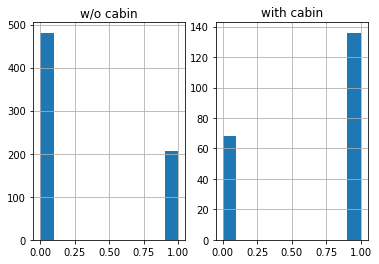

In [109]:
plt.subplot(1,2,2)
train.loc[train.Cabin.notna(), 'Survived'].hist()
plt.title('with cabin')
plt.subplot(1,2,1)
train.loc[train.Cabin.isna(), 'Survived'].hist()
plt.title('w/o cabin')
plt.show()

In [110]:
train['cabin_cat'] = train.Cabin.str[0]
train.cabin_cat.fillna('no_cabin', inplace=True)

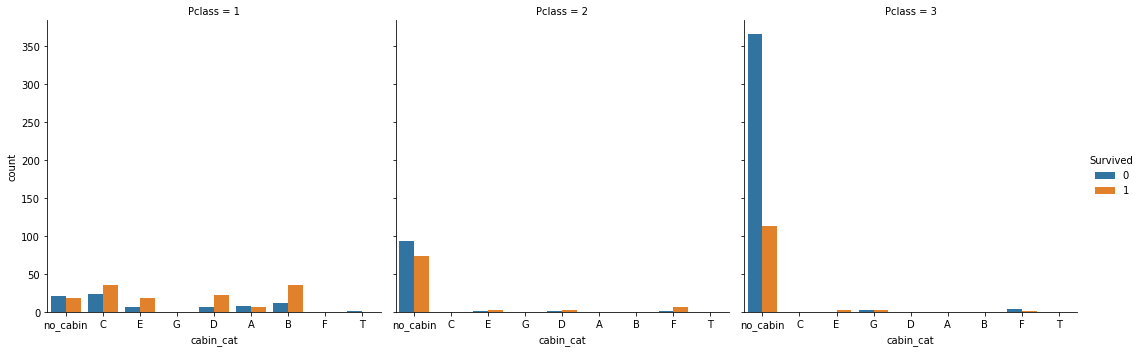

In [111]:
sns.catplot(x='cabin_cat', hue='Survived', kind='count', col='Pclass', data=train)

#### observations:
* Survival rates of which cabin is availale are the same.

#### transformation

In [112]:
# assign all cabins to 'has_cabin'
train.cabin_cat.mask(train.cabin_cat!='no_cabin', 'has_cabin', inplace=True)

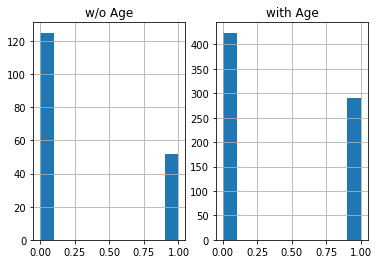

In [113]:
plt.subplot(1,2,2)
train.loc[train.Age.notna(), 'Survived'].hist()
plt.title('with Age')
plt.subplot(1,2,1)
train.loc[train.Age.isna(), 'Survived'].hist()
plt.title('w/o Age')
plt.show()

Passengers with 'Cabin' information is likely to survive

### survive rate wrt Age

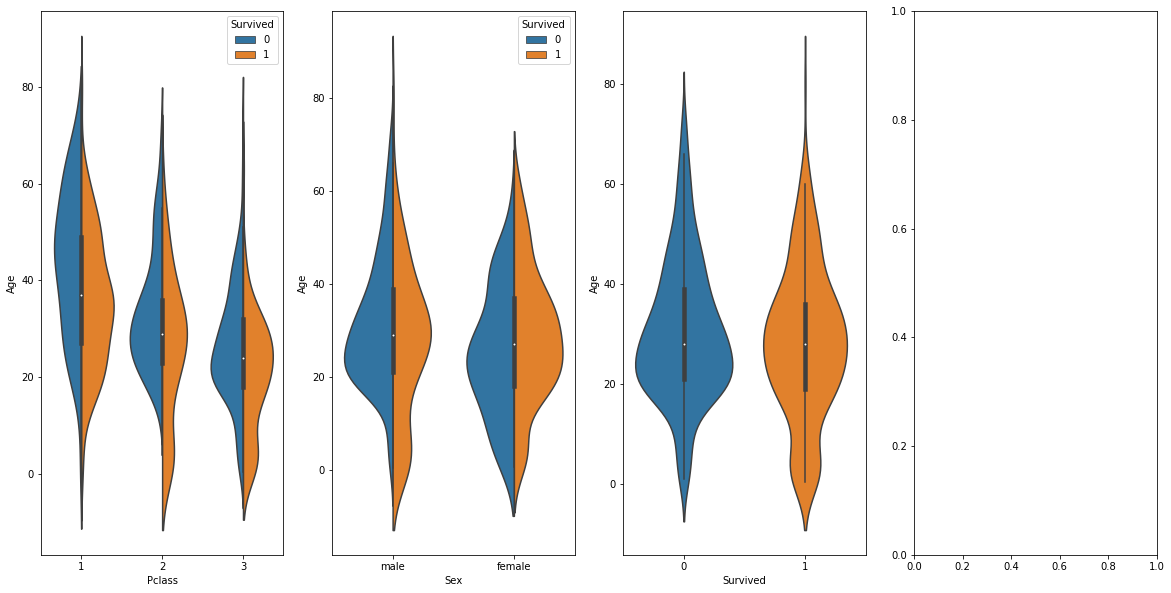

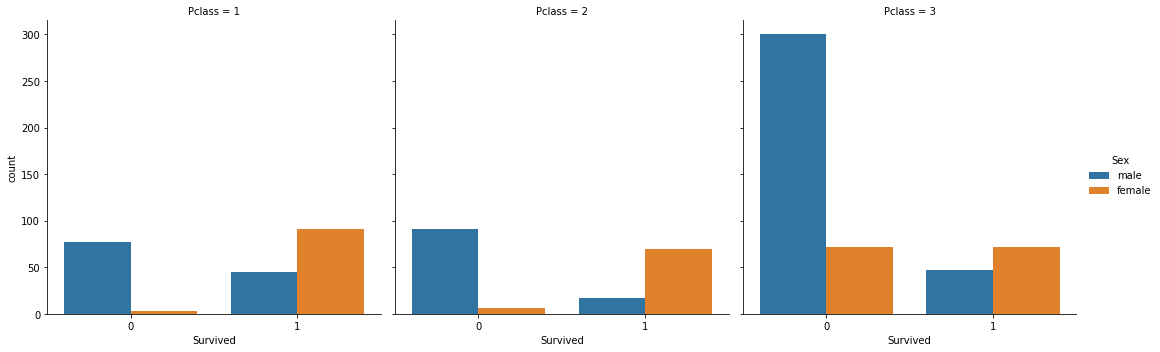

In [114]:
plt.subplots(2,2,figsize=(20,10))
plt.subplot(141)
sns.violinplot(x='Pclass', y='Age', hue='Survived',split=True,data=train)
plt.subplot(142)
sns.violinplot(x='Sex', y='Age', hue='Survived',split=True,data=train)
plt.subplot(143)
sns.violinplot(x='Survived', y='Age', data=train)
plt.subplot(144)
sns.catplot(x='Survived', hue='Sex', col='Pclass', data=train, kind='count')

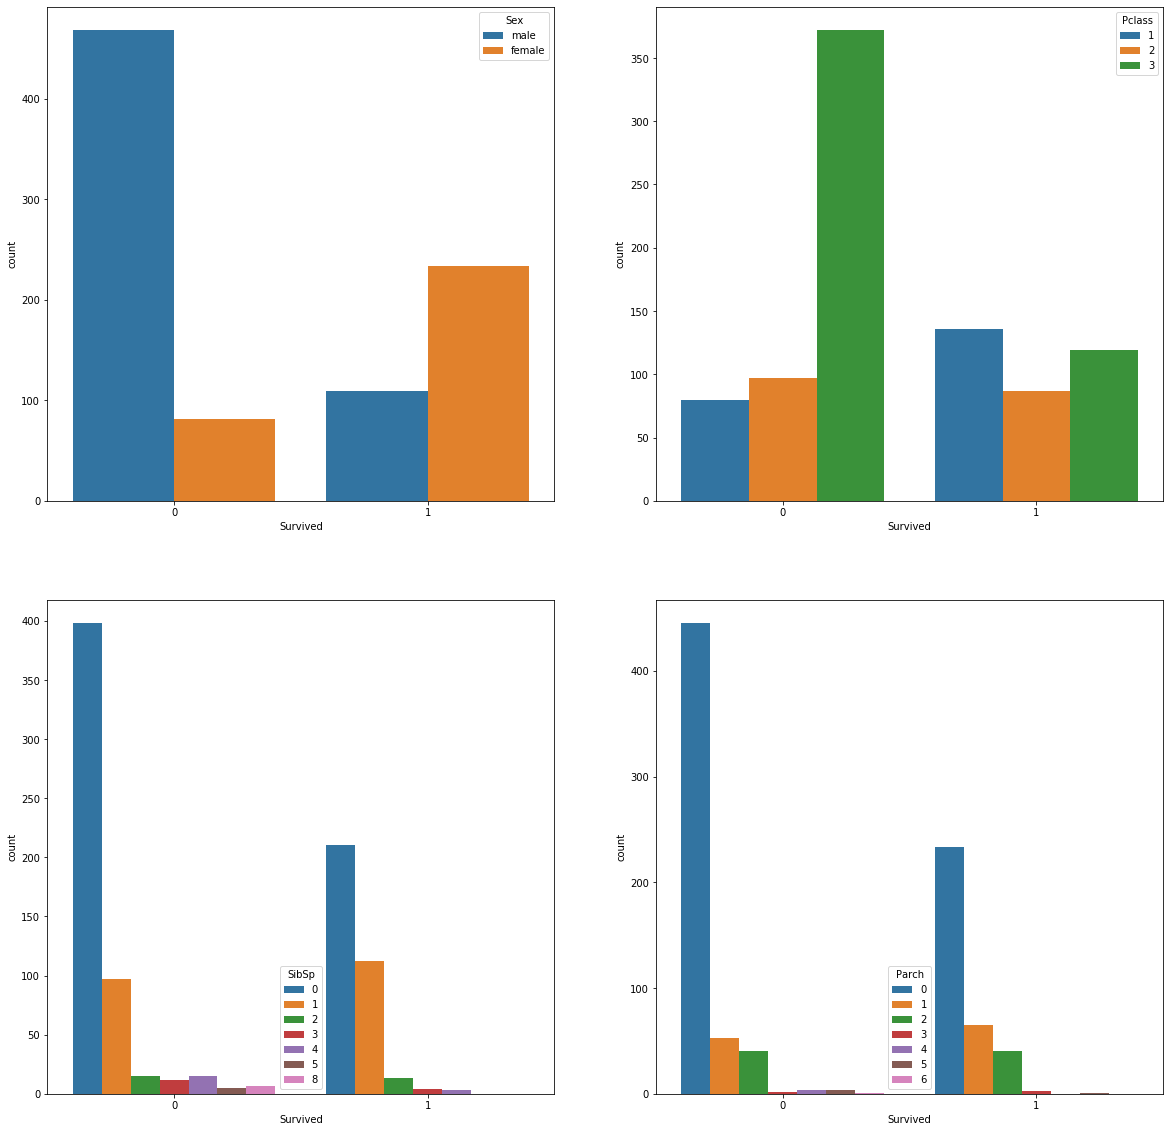

In [115]:
fig, ax= plt.subplots(2,2,figsize=(20,20))
feature_list = ['Sex', 'Pclass', 'SibSp', 'Parch']
for index,feature in enumerate(feature_list):
    sns.countplot(x='Survived', hue=feature, data=train, ax=fig.axes[index])
plt.show()

#### Observations:
* Age <10 and age >50 are more likely to survive.
* Children are more likely to survive.
* 'SibSp' or 'Parch'>0 is more likely to survive

In [116]:
# merge 'Sibsp' and 'Parch'
train['family_size'] = train.SibSp + train.Parch

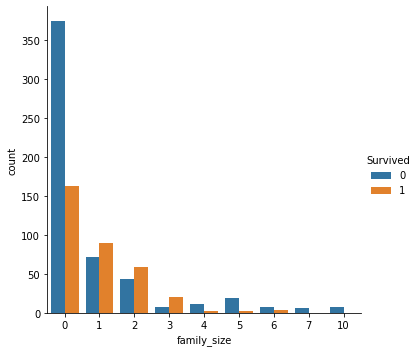

In [117]:
sns.catplot(x='family_size', hue='Survived', data=train, kind='count')

#### observations
* family size >0 and < 4 has a better survival rate.

#### transformations

In [118]:
#categorize family_size to 3 categories
small_size = (train.family_size >0)|(train.family_size < 4)
alone = train.family_size < 1
large_size = train.family_size > 3 
train['family_cat'] = train.family_size.copy()
train.family_cat.mask(small_size, 'small', inplace=True)
train.family_cat.mask(alone, 'alone', inplace=True)
train.family_cat.mask(large_size, 'large', inplace=True)

#'Age' can be inferred by the title in names
train['Initial'] = train.Name.str.extract(r'(\w+\.)')
train['Age'] = train.groupby('Initial')['Age'].transform(lambda x: x.fillna(x.mean())) #fill missing ages with mean value of their group by 'Initial'

In [119]:
a = train.groupby('Initial').aggregate({'Age':['mean'], 'Initial':'count'})
b = pd.crosstab(train.Initial, train.Sex)
a.columns=a.columns.map('_'.join)
pd.concat([a,b], axis=1)

,Age_mean,Initial_count,female,male
Initial,,,,
Capt.,70.000000,1,0,1
Col.,58.000000,2,0,2
Countess.,33.000000,1,1,0
Don.,40.000000,1,0,1
Dr.,42.000000,7,1,6
Jonkheer.,38.000000,1,0,1
Lady.,48.000000,1,1,0
Major.,48.500000,2,0,2
Master.,4.574167,40,0,40


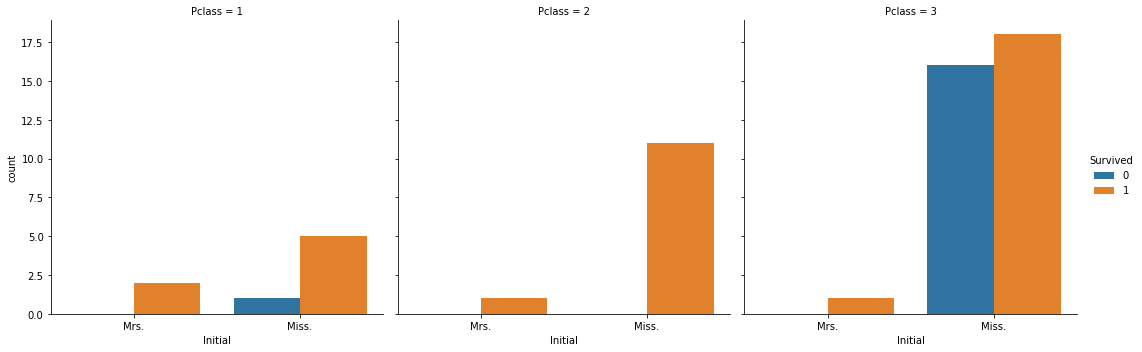

In [120]:
sns.catplot(data=train.loc[(train.Age<18)&(train.Sex=='female')], x='Initial', hue='Survived', col='Pclass', kind='count')

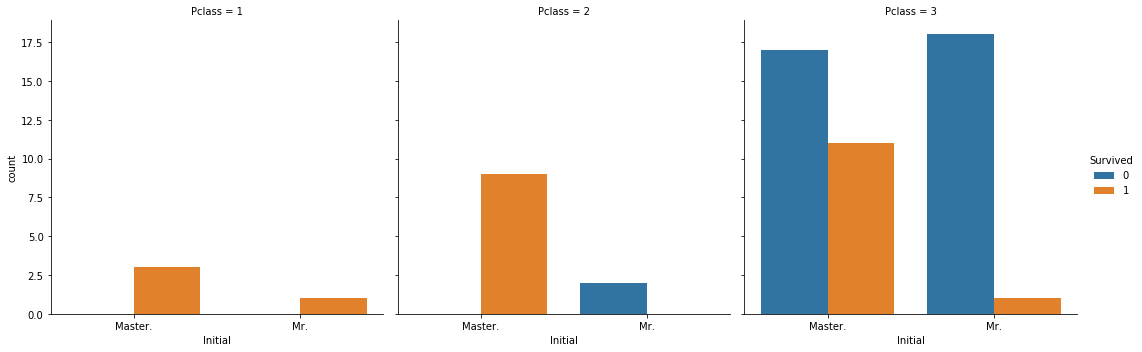

In [121]:
sns.catplot(data=train.loc[(train.Age<18)&(train.Sex=='male')], x='Initial', hue='Survived', col='Pclass', kind='count')

#### observations:
* Boys are titled 'master' while girls are titled 'miss'.
* Even for children, 'Pclass' also decides the survival rate.
* We need to pull out children from 'male' and 'female'

#### transformations:

In [122]:
#assign a new group in 'Sex': 'Children'
train.loc[train.Initial == 'Master.', 'Sex'] = 'Children'
train.loc[(train.Initial == 'Miss.')&(train.Age < 18), 'Sex'] = 'Children'

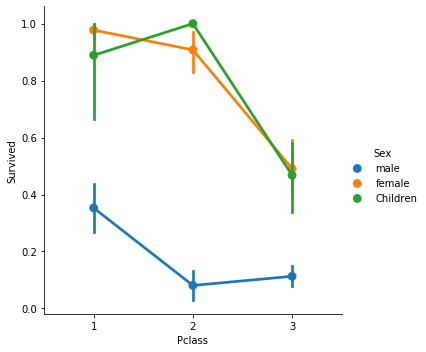

In [123]:
sns.catplot(y='Survived', hue='Sex', x='Pclass', data=train, kind='point')

### Fare

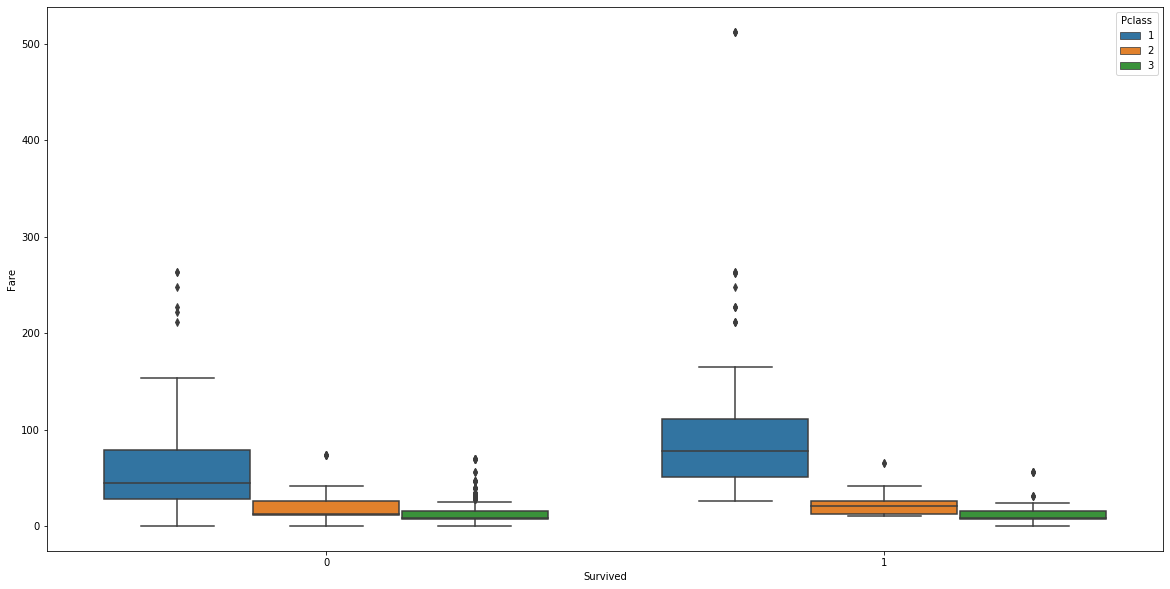

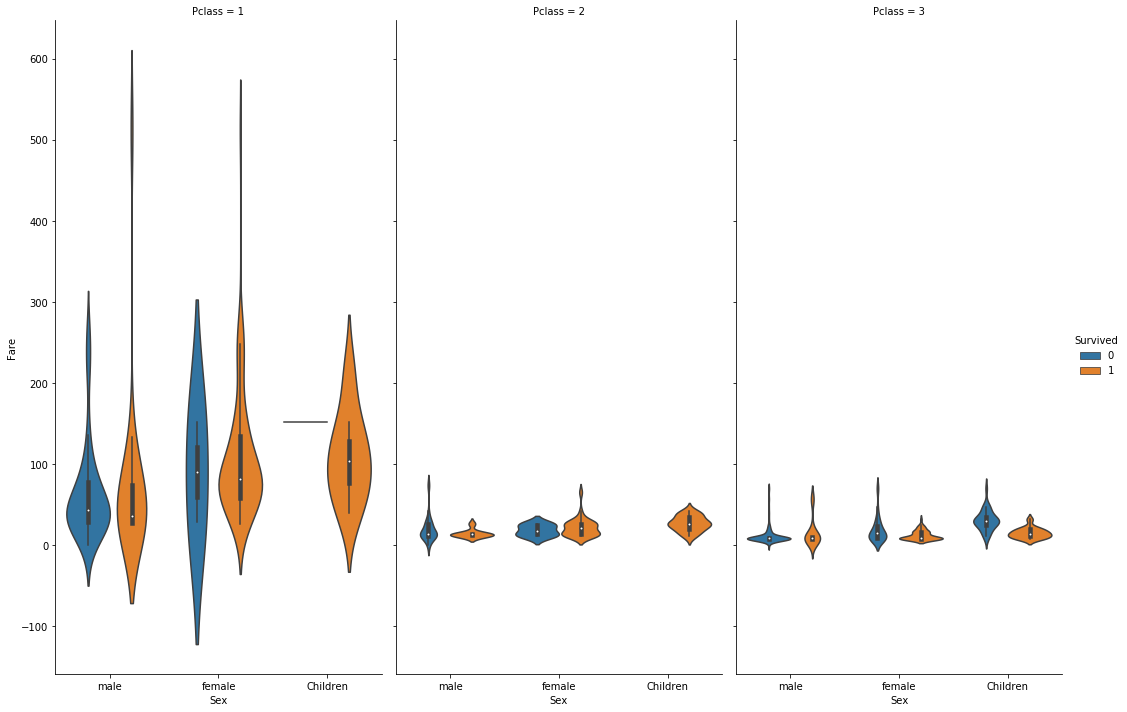

In [124]:
plt.subplots(figsize=(20,10))
sns.boxplot(x='Survived', y='Fare', hue='Pclass', data=train)
sns.catplot(data=train, y='Fare', x='Sex', col='Pclass', hue='Survived', kind='violin',height=10, aspect=0.5)

#### observations:
* 'Pclass' correlates with 'Fare'(reverse)
* 'Fare' higher generally means better survival rate.

#### transformations

In [125]:
# transform 'Fare' into 3 categorical groups
train['fare_range'] = pd.qcut(train.Fare, 3)
train['fare_cat'] = train['fare_range'].map(dict(zip(train['fare_range'].cat.categories,['poor', 'mid', 'rich'])))

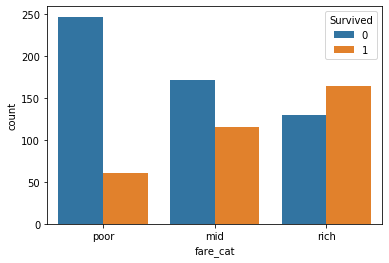

In [126]:
sns.countplot(x='fare_cat', hue='Survived', data=train)

In [127]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_cat,family_size,family_cat,Initial,fare_range,fare_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,no_cabin,1,small,Mr.,"(-0.001, 8.662]",poor
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,has_cabin,1,small,Mrs.,"(26.0, 512.329]",rich
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,no_cabin,0,alone,Miss.,"(-0.001, 8.662]",poor
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,has_cabin,1,small,Mrs.,"(26.0, 512.329]",rich
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,no_cabin,0,alone,Mr.,"(-0.001, 8.662]",poor


### Embarked

In [128]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [129]:
train.Embarked.fillna('S', inplace=True) #fill with the most freq

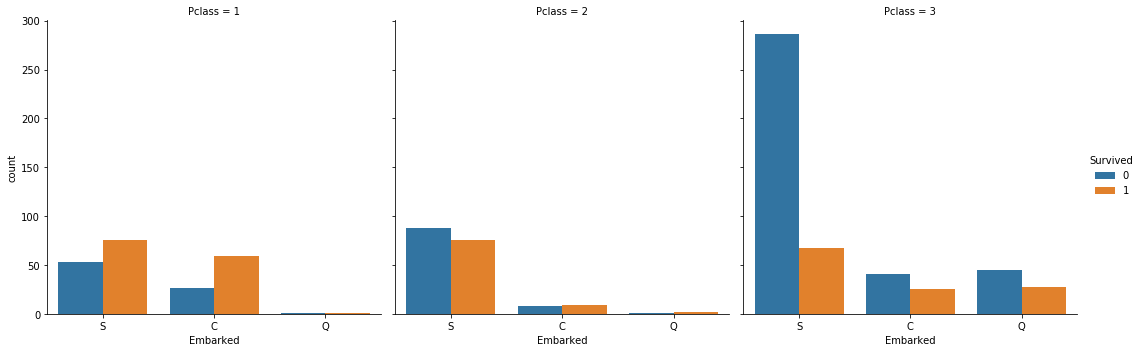

In [130]:
sns.catplot(x='Embarked', hue='Survived', data=train, col='Pclass', kind='count')

#### observations:
* Survival rate depends on 'Pclass' and Embarked place.

In [131]:
remove_list = original_columns.drop(['Embarked', 'Survived', 'Sex', 'Pclass'])
new_list = remove_list.append(pd.Index(['fare_range', 'Initial']))
train.drop(columns=new_list, inplace=True)

# SVM

## One hot coding

In [132]:
Onehot_transformer = OneHotEncoder(sparse=False)
svm = SVC()
clf = Pipeline(steps=[('preprocessor', Onehot_transformer), ('svm', svm)])

In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Embarked       891 non-null object
cabin_cat      891 non-null object
family_size    891 non-null int64
family_cat     891 non-null object
fare_cat       891 non-null category
dtypes: category(1), int64(3), object(4)
memory usage: 49.8+ KB


In [134]:
params = {'svm__C':[0.1, 1, 10], 
          'svm__gamma':['auto', 'scale'],
          'svm__kernel': ['linear', 'sigmoid', 'rbf']}
grid_search = GridSearchCV(estimator=clf, param_grid=params, return_train_score=True)
grid_search.fit(train.drop(columns=['Survived']), train.Survived)

/Users/zhuguanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        OneHotEncoder(categorical_features=None,
                                                      categories=None,
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='error',
                                                      n_values=None,
                                                      sparse=False)),
                                       ('svm',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degr...amma='aut

In [165]:
grid_search.best_score_

0.8305274971941639

In [135]:
pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'mean_train_score']]

,mean_test_score,mean_train_score
0,0.828283,0.828283
1,0.734007,0.746914
2,0.773288,0.790123
3,0.828283,0.828283
4,0.799102,0.806958
5,0.809203,0.829966
6,0.828283,0.828283
7,0.828283,0.828283
8,0.828283,0.829405
9,0.828283,0.828283


In [155]:
def preprocess(df):
    train = df.copy()
    train['cabin_cat'] = train.Cabin.str[0]
    train.cabin_cat.fillna('no_cabin', inplace=True)
    # assign all cabins to 'has_cabin'
    train.cabin_cat.mask(train.cabin_cat!='no_cabin', 'has_cabin', inplace=True)

    # merge 'Sibsp' and 'Parch'
    train['family_size'] = train.SibSp + train.Parch
    #categorize family_size to 3 categories
    small_size = (train.family_size >0)|(train.family_size < 4)
    alone = train.family_size < 1
    large_size = train.family_size > 3 
    train['family_cat'] = train.family_size.copy()
    train.family_cat.mask(small_size, 'small', inplace=True)
    train.family_cat.mask(alone, 'alone', inplace=True)
    train.family_cat.mask(large_size, 'large', inplace=True)

    #'Age' can be inferred by the title in names
    train['Initial'] = train.Name.str.extract(r'(\w+\.)')
    train['Age'] = train.groupby('Initial')['Age'].transform(lambda x: x.fillna(x.mean())) #fill missing ages with mean value of their group by 'Initial'

    #assign a new group in 'Sex': 'Children'
    train.loc[train.Initial == 'Master.', 'Sex'] = 'Children'
    train.loc[(train.Initial == 'Miss.')&(train.Age < 18), 'Sex'] = 'Children'

    # transform 'Fare' into 3 categorical groups
    train['Fare'] = train.groupby('Pclass')['Fare'].transform(lambda x:x.fillna(x.mean()))
    train['fare_range'] = pd.qcut(train.Fare, 3)
    train['fare_cat'] = train['fare_range'].map(dict(zip(train['fare_range'].cat.categories,['poor', 'mid', 'rich'])))

    train.Embarked.fillna('S', inplace=True) #fill with the most freq

    #drop unused columns
    remove_list = original_columns.drop(['Embarked', 'Survived', 'Sex', 'Pclass'])
    new_list = remove_list.append(pd.Index(['fare_range', 'Initial']))
    train.drop(columns=new_list, inplace=True)
    
    return train

In [156]:
test_new = preprocess(test)

In [160]:
test['Survived'] = grid_search.predict(test_new)

In [161]:
submission_df = test[['PassengerId', 'Survived']]

In [164]:
submission_df.to_csv('titanic_submission.csv', index=False)